### MNIST One Pixel Attack V0.0.2

In [1]:
# Tensorflow logging: OFF
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# Generic libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Machine learning
import tensorflow as tf
from keras import backend

# CNN layers
from tensorflow.keras.layers import (Conv2D, MaxPooling2D)
from tensorflow.keras.layers import (Dropout, BatchNormalization, Flatten, Dense)
from tensorflow.keras.layers import LeakyReLU

# MNIST dataset
from tensorflow.keras.datasets import mnist

# Optimiziers
from tensorflow.keras.optimizers import Adam

# Others
from tensorflow.keras import Input

print(tf.__version__)

2.14.0


#### Load Dataset & Pre-Processing

In [3]:
# Load MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [4]:
# Define the input shape of the images and the number of classes
num_classes = 10
img_rows, img_cols = 28, 28

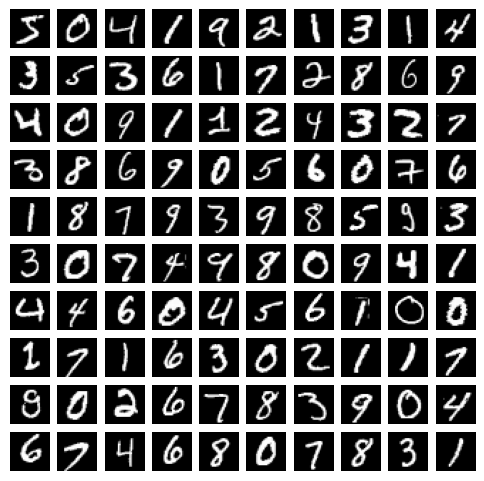

In [5]:
# Show grid of 10x10 images
fig, ax = plt.subplots(10, 10, figsize=(6,6))
for i in range(10):
    for j in range(10):
        ax[i,j].imshow(train_images[i*10+j], cmap='gray')
        ax[i,j].axis('off')
plt.show()

In [6]:
# Normalize the data
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

In [7]:
# Reshape the images to add the mono channel dimension (1)
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)

In [8]:
# Convert class vectors to binary class matrices
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

#### Predictions

In [9]:
# Model name
MODEL_SAVED = "./Models/MNIST_CNN.keras"

# Load the model
model = tf.keras.models.load_model(MODEL_SAVED)

# Get the predictions
predictions = model.predict(test_images)

313/313 [==============================] - 1s 4ms/step


In [10]:
# Print prediction
print(predictions[0])

[5.7622995e-12 5.2644217e-10 1.9288802e-09 1.8686701e-11 5.0521447e-13
 5.3212670e-14 3.3540648e-18 9.9999994e-01 5.1015130e-12 3.9110613e-09]


In [11]:
# Print the predicted class
print(f"Predicted Class: {np.argmax(predictions[0])}")

# Print the confidence
confidences = np.max(predictions, axis=1)
print(f"Confidence: {confidences[i]}")

Predicted Class: 7
Confidence: 0.999812126159668


In [15]:
# Print the real class
print(f"Actual Class: {np.argmax(test_labels[0])}")

Actual Class: 7


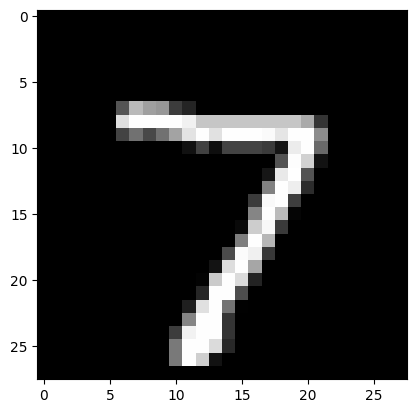

In [13]:
# Print the image
plt.imshow(test_images[0].reshape(28,28), cmap='gray')
plt.show()

#### One Pixel Attack

In [16]:
x_dataset = train_images
y_dataset = train_labels

In [17]:
# Choose the target class for the misclassification
target_class = 7

In [18]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

In [19]:
# Create a function to compute the loss
def get_loss(x, target_class):
    prediction = model(x)
    loss = loss_object(target_class, prediction)
    return loss

# Create a gradient tape to compute gradients
def get_gradients(x, target_class):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = get_loss(x, target_class)
    grads = tape.gradient(loss, x)
    return grads

In [20]:
# Define the attack parameters
num_iterations = 100
epsilon = 0.01

In [21]:
len(x_dataset)

60000

In [22]:
# Perform the One Pixel Attack on the entire dataset
for i in range(len(x_dataset)):
    img = x_dataset[i:i+1] 
    img = tf.convert_to_tensor(img)
    grads = get_gradients(img, target_class)
    img += epsilon * tf.sign(grads)
    x_dataset[i:i+1] = img

#### Adversarial Model

In [23]:
def create_cnn_model(input_shape, num_classes):
    # Input layer
    inputs = Input(shape=input_shape)
    # Convolutional layers
    x = Conv2D(16, kernel_size=(3, 3), activation=LeakyReLU(0.1))(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32, (3, 3), activation=LeakyReLU(0.1))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # Dropout layer
    x = Dropout(0.25)(x)
    # Flatten layer
    x = Flatten()(x)
    # Dense layers
    x = Dense(64, activation=LeakyReLU(0.1))(x)
    x = Dropout(0.4)(x)
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)
    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [24]:
model = create_cnn_model((img_rows, img_cols, 1), num_classes)

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    x_dataset,
    y_dataset,
    epochs=20,
    validation_data=(test_images, test_labels)
)

Epoch 1/20
1875/1875 [==============================] - 20s 10ms/step - loss: 0.2540 - accuracy: 0.9231 - val_loss: 0.0631 - val_accuracy: 0.9796
Epoch 2/20
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0970 - accuracy: 0.9708 - val_loss: 0.0438 - val_accuracy: 0.9865
Epoch 3/20
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0758 - accuracy: 0.9774 - val_loss: 0.0389 - val_accuracy: 0.9866
Epoch 4/20
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0640 - accuracy: 0.9808 - val_loss: 0.0410 - val_accuracy: 0.9873
Epoch 5/20
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0563 - accuracy: 0.9831 - val_loss: 0.0345 - val_accuracy: 0.9883
Epoch 6/20
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0525 - accuracy: 0.9835 - val_loss: 0.0299 - val_accuracy: 0.9898
Epoch 7/20
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0467 - accuracy: 0.9858 - val_loss: 0.0296 -

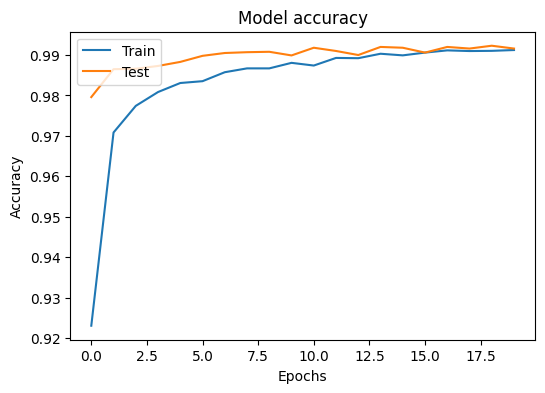

In [26]:
# Plot training & validation accuracy values
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### Save Model

In [27]:
# Save the model
ONEPIXEL_MODEL = "./Models/MNIST_ONEPIXEL.keras"
model.save(ONEPIXEL_MODEL)

#### Predictions

In [28]:
# Perform inference on the adversarial dataset
predictions = model.predict(test_images)

313/313 [==============================] - 1s 4ms/step


In [29]:
# Display the predicted classes and confidences for the entire dataset
predicted_classes = np.argmax(predictions, axis=1)
confidences = np.max(predictions, axis=1)

for i in range(len(predicted_classes)):
    print(f"Sample {i + 1}: Predicted Class - {predicted_classes[i]}, Confidence - {confidences[i]:.2f}")

Sample 1: Predicted Class - 7, Confidence - 1.00
Sample 2: Predicted Class - 2, Confidence - 1.00
Sample 3: Predicted Class - 1, Confidence - 1.00
Sample 4: Predicted Class - 0, Confidence - 1.00
Sample 5: Predicted Class - 4, Confidence - 1.00
Sample 6: Predicted Class - 1, Confidence - 1.00
Sample 7: Predicted Class - 4, Confidence - 1.00
Sample 8: Predicted Class - 9, Confidence - 1.00
Sample 9: Predicted Class - 5, Confidence - 1.00
Sample 10: Predicted Class - 9, Confidence - 1.00
Sample 11: Predicted Class - 0, Confidence - 1.00
Sample 12: Predicted Class - 6, Confidence - 1.00
Sample 13: Predicted Class - 9, Confidence - 1.00
Sample 14: Predicted Class - 0, Confidence - 1.00
Sample 15: Predicted Class - 1, Confidence - 1.00
Sample 16: Predicted Class - 5, Confidence - 1.00
Sample 17: Predicted Class - 9, Confidence - 1.00
Sample 18: Predicted Class - 7, Confidence - 1.00
Sample 19: Predicted Class - 3, Confidence - 0.95
Sample 20: Predicted Class - 4, Confidence - 1.00
Sample 21

In [30]:
# Print prediction
print(predictions[0])

[3.2323643e-15 6.9366609e-12 5.5138416e-12 2.9544331e-12 3.7952662e-13
 1.0484193e-14 7.8975524e-19 9.9999994e-01 2.6857442e-13 8.4333651e-12]


In [31]:
# Print the predicted class
print(f"Predicted Class: {np.argmax(predictions[0])}")

# Print the confidence
confidences = np.max(predictions, axis=1)
print(f"Confidence: {confidences[i]}")

Predicted Class: 7
Confidence: 0.9999979138374329


In [32]:
# Print the real class
print(f"Actual Class: {np.argmax(test_labels[0])}")

Actual Class: 7


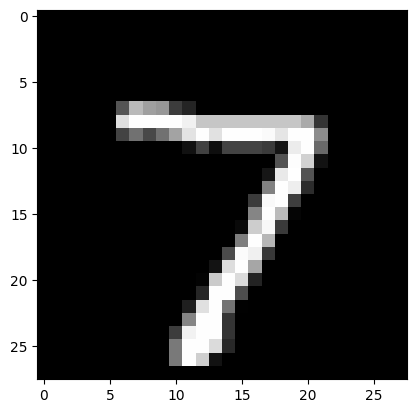

In [33]:
# Print the image
plt.imshow(test_images[0].reshape(28,28), cmap='gray')
plt.show()